In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import copy
import os
import torch
from torch.utils.data import Dataset
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision
import torchvision.transforms.functional as tf
from torchvision.models.detection.ssd import SSDHead,det_utils
from torchvision.models.detection import ssd300_vgg16,SSD300_VGG16_Weights
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pycocotools

%matplotlib inline
sns.set_style("dark")

In [3]:
images_dir="/content/drive/MyDrive/BCCD_Dataset-master/BCCD/JPEGImages"
labels_dir="/content/drive/MyDrive/Dataset/BCCD/Labels"

#label 0 is fixed for background
classes=["Background","RBC", "WBC", "Platelets"]

num_classes=4
device="cuda" if torch.cuda.is_available() else "cpu"
batch_size=4
epochs=50
learning_rate=3e-4

model_weights_file="model.pth"

threshold=0.3
iou_threshold=0.8

Аугментация данных

In [4]:
train_transform=A.Compose([A.HorizontalFlip(),
                           A.ShiftScaleRotate(rotate_limit=15,value=0,
                                              border_mode=cv2.BORDER_CONSTANT),
                           A.CLAHE(),
                           A.GaussNoise()],
                          bbox_params=A.BboxParams(format="pascal_voc",min_visibility=0.7,
                                                   label_fields=["labels"]))

Формирование датасета для тренировки

In [5]:
class Cells(Dataset):
    def __init__(self,imgs_dir,annot_dir,transform=None):
        super().__init__()
        self.imgs_dir=imgs_dir
        self.labels_dir=annot_dir
        self.imgs_list=sorted([img_name for img_name in os.listdir(self.imgs_dir)
                               if img_name.endswith(".jpg")])
        self.transform=transform

    def __len__(self):
        return len(self.imgs_list)

    def __getitem__(self,idx):
        img_name=self.imgs_list[idx]
        img_path=os.path.join(self.imgs_dir,img_name)
        img=Image.open(img_path)
        w,h=img.size
        img=np.asarray(img)

        try:
            annot_name=img_name[:-4]+".txt"
            annot_path=os.path.join(self.labels_dir,annot_name)
            annot_data=pd.read_csv(annot_path,delimiter=" ",header=None).values
            labels=annot_data[:,0]
            labels=labels+1
            boxes=annot_data[:,1:5]

            xmin=((boxes[:,0]-boxes[:,2]/2)*w)[:,None]
            ymin=((boxes[:,1]-boxes[:,3]/2)*h)[:,None]
            xmax=((boxes[:,0]+boxes[:,2]/2)*w)[:,None]
            ymax=((boxes[:,1]+boxes[:,3]/2)*h)[:,None]
            boxes=np.concatenate((xmin,ymin,xmax,ymax),axis=1)

            if self.transform is not None:
                transformed=self.transform(image=img,bboxes=boxes,labels=labels)
                img=transformed["image"]
                boxes=transformed["bboxes"]
                labels=transformed["labels"]

            if len(np.array(boxes).shape)!=2 or np.array(boxes).shape[-1]!=4:
                boxes=[[0.0,0.0,1.0,1.0]]
                labels=[0]

        except:
            boxes=[[0.0,0.0,1.0,1.0]]
            labels=[0]

        img=img/255
        img=tf.to_tensor(img)
        img=img.to(dtype=torch.float32)
        target={}
        target["boxes"]=torch.tensor(boxes,dtype=torch.float32)
        target["labels"]=torch.tensor(labels,dtype=torch.int64)
        target["id"]=torch.tensor(idx)

        return img,target

In [6]:
train_ds=Cells(images_dir,labels_dir,train_transform)
val_ds=Cells(images_dir,labels_dir)

In [7]:
idxs=list(range(len(train_ds)))

np.random.shuffle(idxs)
train_idx=idxs[:int(0.8*len(train_ds))]
val_idx=idxs[int(0.8*len(train_ds)):]

train_ds=Subset(train_ds,train_idx)
val_ds=Subset(val_ds,val_idx)

Визуализация данных

In [8]:
def show_bbox(img,target,axis,color=(0,255,0)):
    img=np.transpose(img.cpu().numpy(),(1,2,0))
    boxes=target["boxes"].cpu().numpy().astype("int")
    labels=target["labels"].cpu().numpy()
    img=img.copy()
    for i,box in enumerate(boxes):
        idx=int(labels[i])
        text=classes[idx]

        cv2.rectangle(img,(box[0],box[1]),(box[2],box[3]),color,2)
        y=box[1]-10 if box[1]-10>10 else box[1]+10
        cv2.putText(img,text,(box[0],y),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)

    axis.imshow(img)
    axis.axis("off")

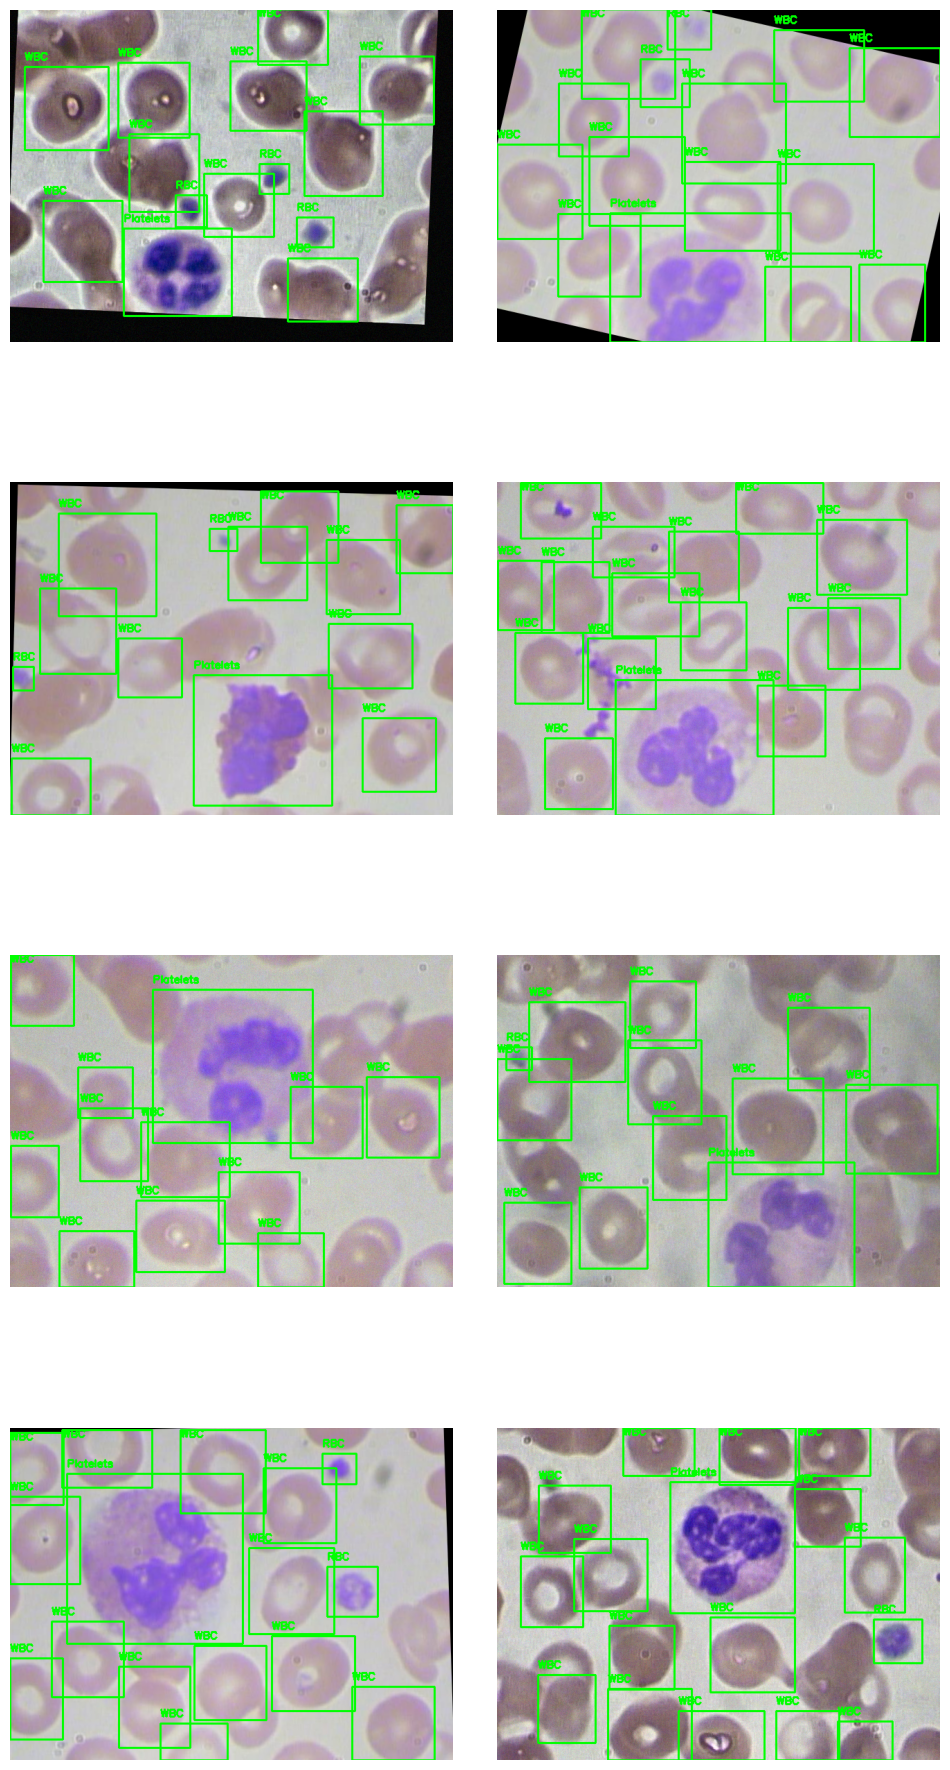

In [9]:
fig,axes=plt.subplots(4,2,figsize=(12,24))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
ax=axes.flatten()

idxs=np.random.choice(range(len(train_ds)),8)

for i,idx in enumerate(idxs):
    img,target=train_ds[idx]
    show_bbox(img,target,axis=ax[i])

plt.savefig("2.png")

DataLoader

In [10]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [11]:
train_dl=DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=os.cpu_count(),
                    collate_fn=collate_fn,
                    pin_memory=True if device=="cuda" else False)
val_dl=DataLoader(val_ds,batch_size=batch_size,shuffle=False,num_workers=os.cpu_count(),
                  collate_fn=collate_fn,
                  pin_memory=True if device=="cuda" else False)

Создание модели и тренировка

In [12]:
model=ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT)

in_channels=det_utils.retrieve_out_channels(model.backbone,(300,300))
num_anchors=model.anchor_generator.num_anchors_per_location()
model.head=SSDHead(in_channels=in_channels,num_anchors=num_anchors,
                   num_classes=num_classes)

model.to(device)

Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:00<00:00, 154MB/s]


SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [13]:
for params in model.backbone.features.parameters():
    params.requires_grad=False

parameters=[params for params in model.parameters() if params.requires_grad]

optimizer=optim.Adam(parameters,lr=learning_rate)
lr_scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1,
                                                  patience=7, threshold=0.0001)

In [14]:
def get_lr(optimizer):
    for params in optimizer.param_groups:
        return params["lr"]

In [15]:
loss_history={"training_loss":[],
              "validation_loss":[]}

train_len=len(train_dl.dataset)
val_len=len(val_dl.dataset)

best_validation_loss=np.inf
best_weights=copy.deepcopy(model.state_dict())

for epoch in range(epochs):

    training_loss=0.0
    validation_loss=0.0

    current_lr=get_lr(optimizer)

    #During training, the model expects both the input tensors, as well as a targets
    model.train()
    for imgs,targets in train_dl:
        imgs=[img.to(device) for img in imgs]
        targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]

        loss_dict=model(imgs,targets)
        losses=sum(loss for loss in loss_dict.values())
        training_loss+=losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    with torch.no_grad():
        for imgs,targets in val_dl:
            imgs=[img.to(device) for img in imgs]
            targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]

            loss_dict=model(imgs,targets)
            losses=sum(loss for loss in loss_dict.values())
            validation_loss+=losses.item()


    lr_scheduler.step(validation_loss)
    if current_lr!=get_lr(optimizer):
        print("Loading best Model weights")
        model.load_state_dict(best_weights)

    if validation_loss<best_validation_loss:
        best_validation_loss=validation_loss
        best_weights=copy.deepcopy(model.state_dict())
        print("Updating Best Model weights")


    loss_history["training_loss"].append(training_loss/train_len)
    loss_history["validation_loss"].append(validation_loss/val_len)

    print(f"\n{epoch+1}/{epochs}")
    print(f"Training Loss: {training_loss/train_len}")
    print(f"Validation_loss: {validation_loss/val_len}")
    print("\n"+"*"*50)

torch.save(best_weights,model_weights_file)

Updating Best Model weights

1/50
Training Loss: 1.4430733349724734
Validation_loss: 1.114080749145926

**************************************************
Updating Best Model weights

2/50
Training Loss: 0.9333178997039795
Validation_loss: 0.8676083806442888

**************************************************
Updating Best Model weights

3/50
Training Loss: 0.7708155961380792
Validation_loss: 0.7840642047255006

**************************************************
Updating Best Model weights

4/50
Training Loss: 0.7093255470708474
Validation_loss: 0.7486962553572981

**************************************************
Updating Best Model weights

5/50
Training Loss: 0.6819703513404348
Validation_loss: 0.7198310388277654

**************************************************
Updating Best Model weights

6/50
Training Loss: 0.6560452197425554
Validation_loss: 0.6915206615238974

**************************************************
Updating Best Model weights

7/50
Training Loss: 0.63016466258727

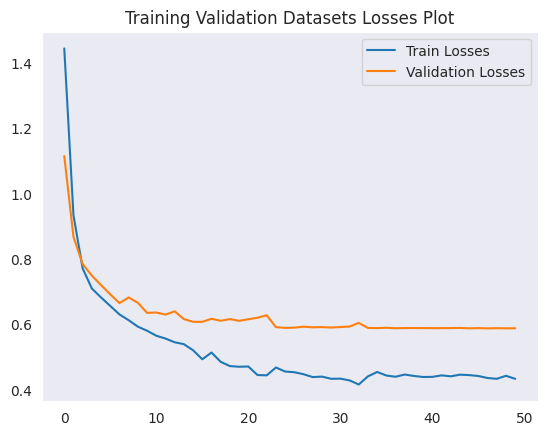

In [16]:
sns.lineplot(x=range(epochs),y=loss_history["training_loss"],label="Train Losses");
sns.lineplot(x=range(epochs),y=loss_history["validation_loss"],label="Validation Losses");
plt.title("Training Validation Datasets Losses Plot");
plt.legend();

Оценка полученных результатов

In [17]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 9.4 MB/s eta 0:00:00


In [18]:
import torchmetrics
from torchmetrics.detection import MeanAveragePrecision

In [19]:
model_learned_weights="/content/model.pth"
model=ssd300_vgg16(weights=None,weights_backbone=None)

in_channels=det_utils.retrieve_out_channels(model.backbone,(300,300))
num_anchors=model.anchor_generator.num_anchors_per_location()
model.head=SSDHead(in_channels=in_channels,num_anchors=num_anchors,
                   num_classes=num_classes)

model.load_state_dict(torch.load(model_learned_weights,map_location=device))
model.to(device)

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [20]:
def preprocess_bbox(prediction):

    """Non-max suppression is the final step of these object detection algorithms and is
       used to select the most appropriate bounding box for the object.
       The NMS takes two things into account
        -The objectiveness score is given by the model
        -The overlap or IOU of the bounding boxes"""

    processed_bbox={}

    boxes=prediction["boxes"][prediction["scores"]>=threshold]
    scores=prediction["scores"][prediction["scores"]>=threshold]
    labels=prediction["labels"][prediction["scores"]>=threshold]
    nms=torchvision.ops.nms(boxes,scores,iou_threshold=iou_threshold)

    processed_bbox["boxes"]=boxes[nms]
    processed_bbox["scores"]=scores[nms]
    processed_bbox["labels"]=labels[nms]

    return processed_bbox

In [21]:
metric=MeanAveragePrecision(box_format='xyxy',class_metrics=True)
metric.to(device)

model.eval()
with torch.no_grad():
    for imgs,targets in val_dl:
        imgs=[img.to(device) for img in imgs]
        targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]
        predictions=model(imgs)

        results=[]
        for prediction in predictions:
            results.append(preprocess_bbox(prediction))

        metric.update(results,targets)

results=metric.compute()

In [22]:
mean_ap=results["map"].item()
mean_ap_50=results["map_50"].item()
mean_ap_75=results["map_75"].item()

print(f"Mean Average Precision[0.5:0.95:0.05] : {mean_ap:.4f}")
print(f"Mean Average Precision @ 0.5          : {mean_ap_50:.4f}")
print(f"Mean Average Precision @ 0.75         : {mean_ap_75:.4f}")

Mean Average Precision[0.5:0.95:0.05] : 0.4964
Mean Average Precision @ 0.5          : 0.7869
Mean Average Precision @ 0.75         : 0.5737


In [23]:
if (len(results["map_per_class"])==len(classes)):
    map_per_class=results["map_per_class"][1:].tolist()
    mar_100_per_class=results["mar_100_per_class"][1:].tolist()
    obj_cls=classes[1:]
else:
    map_per_class=results["map_per_class"].tolist()
    mar_100_per_class=results["mar_100_per_class"].tolist()
    obj_cls=classes[1:]

data=list(zip(map_per_class,mar_100_per_class))
columns=["Mean_Avg_Precision","Mean_Avg_Recall"]
cls_map=pd.DataFrame(data,columns=columns,index=obj_cls)
cls_map.style.background_gradient(subset=columns,cmap="YlOrRd",high=0.75)

,Mean_Avg_Precision,Mean_Avg_Recall
RBC,0.325482,0.372368
WBC,0.478098,0.567330
Platelets,0.685757,0.746753


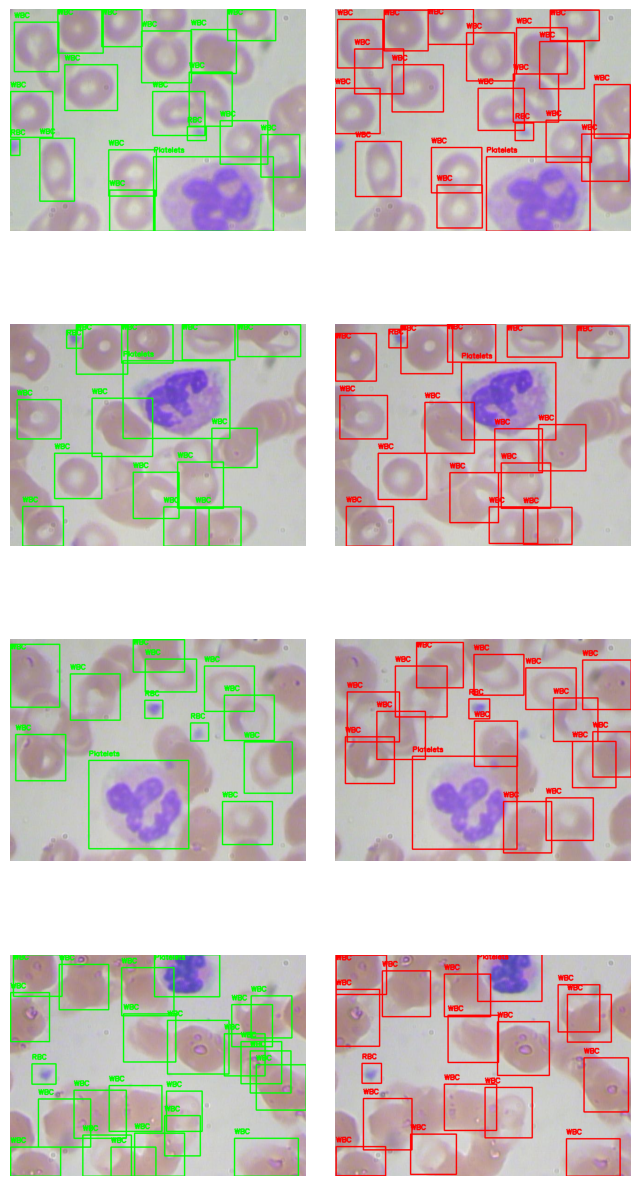

In [24]:
fig,axes=plt.subplots(4,2,figsize=(8,16))
plt.subplots_adjust(wspace=0.1,hspace=0.1)

imgs,targets=next(iter(val_dl))
model.eval()
with torch.no_grad():
    output=model([img.to(device) for img in imgs])

for i,idx in enumerate(range(len(imgs))):
    img=imgs[idx]
    prediction=output[idx]

    #real bounding boxes
    show_bbox(img,targets[idx],axes[i,0],color=(0,255,0))

    #predicted bounding box
    predict=preprocess_bbox(prediction)

    show_bbox(img,predict,axes[i,1],color=(255,0,0));

plt.savefig("4.png")